In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read, write
from dynasor.qpoints import get_spherical_qpoints
from dynasor import compute_static_structure_factors, Trajectory
from dynasor.post_processing import get_spherically_averaged_sample_smearing 

In [408]:

os.chdir('/Users/prakriti/2024_BaZrS3_Phase_Transitions/')
structure_tags = ['BaZrS3-spg221-Pm3m','BaZrS3-spg140-I4mcm','BaZrS3-spg62-Pnma']
#structure_tags = ['BaZrS3-spg221-Pm3m','BaZrS3-spg140-I4mcm']
data_dict = dict()
for structure_tag in structure_tags:

    # write dummy traj
    atoms = read(f'{structure_tag}.xyz')
    atoms.calc = None
    print(atoms)
    n_atoms = len(atoms)
    traj = [atoms for _ in range(2)]
    write('tmp_traj.xyz', traj)

    # setup traj
    traj = Trajectory('tmp_traj.xyz', trajectory_format='extxyz', atomic_indices="read_from_trajectory")

    # q-points
    q_max = 3
    q_points = get_spherical_qpoints(traj.cell, q_max=q_max)

    # compute Sq
    sample = compute_static_structure_factors(traj, q_points)
    q_norms = np.linalg.norm(sample.q_points, axis=1)
    data_dict[structure_tag] = q_norms, sample.Sq / n_atoms

Atoms(symbols='BaZrS3', pbc=True, cell=[5.01430004764237, 5.01430004764237, 5.01430004764237])
INFO: Trajectory file: tmp_traj.xyz
INFO: Total number of particles: 5
INFO: Number of atom types: 3
INFO: Number of atoms of type Ba: 1
INFO: Number of atoms of type S: 3
INFO: Number of atoms of type Zr: 1
INFO: Simulation cell (in Angstrom):
[[5.01430005 0.         0.        ]
 [0.         5.01430005 0.        ]
 [0.         0.         5.01430005]]
INFO: Number of q-points: 17
Atoms(symbols='Ba2S6Zr2', pbc=True, cell=[[-3.46814503, 3.46814517, 5.09857675], [3.46814513, -3.46814507, 5.09857675], [3.46814507, 3.46814503, -5.09857682]], forces=...)
INFO: Trajectory file: tmp_traj.xyz
INFO: Total number of particles: 10
INFO: Number of atom types: 3
INFO: Number of atoms of type Ba: 2
INFO: Number of atoms of type S: 6
INFO: Number of atoms of type Zr: 2
INFO: Simulation cell (in Angstrom):
[[-3.46814503  3.46814517  5.09857675]
 [ 3.46814513 -3.46814507  5.09857675]
 [ 3.46814507  3.46814503 

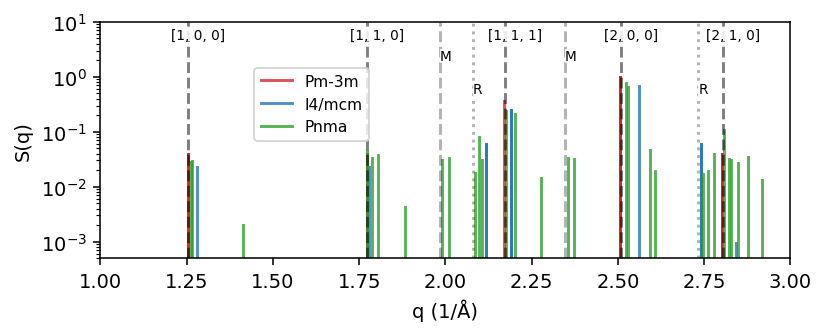

In [426]:
# plot setup
fig = plt.figure(figsize=(6.0, 2.5), dpi=140)
ax1 = fig.add_subplot()

colors = dict()
colors['BaZrS3-spg221-Pm3m'] = 'tab:red'
colors['BaZrS3-spg140-I4mcm'] = 'tab:blue'
colors['BaZrS3-spg62-Pnma'] = 'tab:green'

labels = dict()
labels['BaZrS3-spg221-Pm3m'] = r'Pm-3m'
labels['BaZrS3-spg140-I4mcm'] = r'I4/mcm'
labels['BaZrS3-spg62-Pnma'] = r'Pnma'

xlim = [1, 3]
ylim = [0.0005, 10]
alpha = 0.8


# plot S(q) as vertical lines
for structure_tag, (q_norms, Sq) in data_dict.items():
    for q, S in zip(q_norms, Sq):
        ax1.plot([q, q], [0, S[0]], color=colors[structure_tag], alpha=alpha)
    ax1.plot(np.nan, np.nan, color=colors[structure_tag], alpha=alpha, label=labels[structure_tag])


# Mark the cubic gamma-points
alat = 5.01
alpha = 0.5
fs = 7
bbox = dict(facecolor='w', edgecolor='none', alpha=0.85, pad=0.0)

q_vecs = [[1, 0, 0], [1, 1, 0], [1, 1, 1], [2, 0, 0], [2,1,0]]
for qvec in q_vecs:
    q = 2 * np.pi / alat * np.linalg.norm(qvec)
    ax1.axvline(x=q, ls='--', color='k', alpha=alpha)
    ax1.text(q -0.05, 0.5 * ylim[-1], str(qvec), fontsize=fs, bbox=bbox)

# Mark the cubic M-points
qvec_R1 = [1.5, 0.5, 0.5]
qvec_R2 = [1.5, 1.5, 0.5]
#qvec_R3 = [0.5, 0.5, 0.5]
qvec_M1 = [1.5, 0.5, 0]
qvec_M2 = [1.5, 0.5, 1.0]
q_M1 = 2 * np.pi / alat * np.linalg.norm(qvec_M1)
q_M2 = 2 * np.pi / alat * np.linalg.norm(qvec_M2)
q_R1 = 2 * np.pi / alat * np.linalg.norm(qvec_R1)
q_R2 = 2 * np.pi / alat * np.linalg.norm(qvec_R2)
ax1.axvline(x=q_M1, ls='--', color='k', alpha=alpha-0.2)
ax1.axvline(x=q_M2, ls='--', color='k', alpha=alpha-0.2)
ax1.axvline(x=q_R1, ls=':', color='k', alpha=alpha-0.2)
ax1.axvline(x=q_R2, ls=':', color='k', alpha=alpha-0.2)
ax1.text(q_M1, 0.2 * ylim[-1], 'M', fontsize=fs, bbox=bbox)
ax1.text(q_M2, 0.2 * ylim[-1], 'M', fontsize=fs, bbox=bbox)
ax1.text(q_R1, 0.05 * ylim[-1], 'R', fontsize=fs, bbox=bbox)
ax1.text(q_R2, 0.05 * ylim[-1], 'R', fontsize=fs, bbox=bbox)


ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_yscale('log')
ax1.legend(loc=1, fontsize=8, bbox_to_anchor=(0.4, 0.84))
ax1.set_xlabel('q (1/Å)')
ax1.set_ylabel('S(q)')

fig.tight_layout()

# MD 


In [200]:
import os 
q_max = 3.0
q_linspace = np.linspace(0, q_max, 2000)
q_width = 0.001
data_dict_qwidths = dict()
# setup traj
for temp in np.arange(620,1200,10):
    text1 = f'/Users/prakriti/2024_BaZrS3_Phase_Transitions/XRD/XRD/'
    if temp < 890:
        dirname = f'BaZrS3_I4mcm_size4_T{temp}_seekpath/'
    else:
        dirname = f'BaZrS3_Pm-3m_size10_T{temp}_seekpath/'
    if not os.path.exists(f'{text1}{dirname}/dump.extxyz'):
        os.chdir(f'{text1}{dirname}')
        print("here")
        os.system('mv dump.xyz dump.extxyz')
        os.chdir(f'../../')
    traj = Trajectory(text1 + dirname + 'dump.extxyz', trajectory_format='extxyz')
#dirs = ['BaZrS3_Pm-3m_size10_T1100_seekpath/','BaZrS3_Pm-3m_size10_T1000_seekpath/', 'BaZrS3_Pm-3m_size10_T900_seekpath/', 'BaZrS3_I4mcm_size4_T800_seekpath/', 'BaZrS3_I4mcm_size4_T700_seekpath/']
#for i in dirs:
    
#    dirname = f'XRD/XRD/{i}'
#    traj = Trajectory(dirname + 'dump.extxyz', trajectory_format='extxyz')


    # generate all q-points in supercell
    q_points = get_spherical_qpoints(traj.cell, q_max=q_max)

    # compute Sq
    sample = compute_static_structure_factors(traj, q_points)

    sample_averaged = get_spherically_averaged_sample_smearing(sample, q_norms=q_linspace, q_width=q_width)
    data_dict_qwidths[temp] = sample_averaged.q_norms, sample_averaged.Sq

INFO: Trajectory file: /Users/prakriti/2024_BaZrS3_Phase_Transitions/XRD/XRD/BaZrS3_I4mcm_size4_T620_seekpath/dump.extxyz
INFO: Total number of particles: 5120
INFO: Number of atom types: 1
INFO: Number of atoms of type X: 5120
INFO: Simulation cell (in Angstrom):
[[56.87521071  0.          0.        ]
 [ 0.         56.87521071  0.        ]
 [ 0.          0.         40.71969626]]
INFO: Number of q-points: 8233
INFO: Trajectory file: /Users/prakriti/2024_BaZrS3_Phase_Transitions/XRD/XRD/BaZrS3_I4mcm_size4_T630_seekpath/dump.extxyz
INFO: Total number of particles: 5120
INFO: Number of atom types: 1
INFO: Number of atoms of type X: 5120
INFO: Simulation cell (in Angstrom):
[[56.88930901  0.          0.        ]
 [ 0.         56.88930901  0.        ]
 [ 0.          0.         40.71782537]]
INFO: Number of q-points: 8243
INFO: Trajectory file: /Users/prakriti/2024_BaZrS3_Phase_Transitions/XRD/XRD/BaZrS3_I4mcm_size4_T640_seekpath/dump.extxyz
INFO: Total number of particles: 5120
INFO: Number

In [320]:
from collections import OrderedDict
res = dict(reversed(list(data_dict_qwidths.items())))

700
800
900
1000
1100


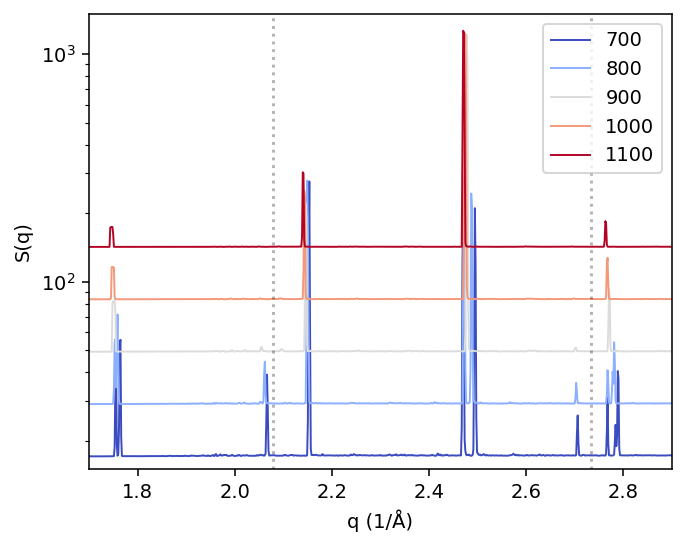

In [344]:
count = 10
fig = plt.figure(figsize=(5.0, 4), dpi=140)
ax = fig.add_subplot(111)
n = 5
ax.set_prop_cycle('color',[plt.cm.coolwarm(i) for i in np.linspace(0, 1, n)])
# plotting of gaussian spherical average S(q)
for temp, (q, Sq) in data_dict_qwidths.items():
    if temp%100 == 0:
        count = count*1.7
        print(temp)
        ax.plot(q, Sq+(count), '-', label=rf'{temp}', lw=1)

ax.set_xlabel('q (1/Å)')
ax.set_ylabel('S(q)')
ax.set_xlim([1.7, 2.9])
ax.legend(loc=2, fontsize=7)
#if log_yscale:
ax.set_yscale('log')
ax.set_ylim(15, 1500)
#else:
#ax.set_ylim(0.0, 10)

# Mark the cubic M-points
qvec_R1 = [1.5, 0.5, 0.5]
qvec_R2 = [1.5, 1.5, 0.5]
#qvec_R3 = [0.5, 0.5, 0.5]
qvec_M1 = [1.5, 0.5, 0]
qvec_M2 = [1.5, 0.5, 1.0]
q_R1 = 2 * np.pi / alat * np.linalg.norm(qvec_R1)
q_R2 = 2 * np.pi / alat * np.linalg.norm(qvec_R2)
q_R3 = 2 * np.pi / alat * np.linalg.norm(qvec_R3)
q_M1 = 2 * np.pi / alat * np.linalg.norm(qvec_M1)
q_M2 = 2 * np.pi / alat * np.linalg.norm(qvec_M2)
ax.axvline(x=q_R1, ls=':', color='k', alpha=alpha-0.2)
ax.axvline(x=q_R2, ls=':', color='k', alpha=alpha-0.2)
ax.axvline(x=q_R3, ls=':', color='k', alpha=alpha-0.2)
ax.legend(loc=1)
fig.tight_layout()

700
800
900
1000
1100


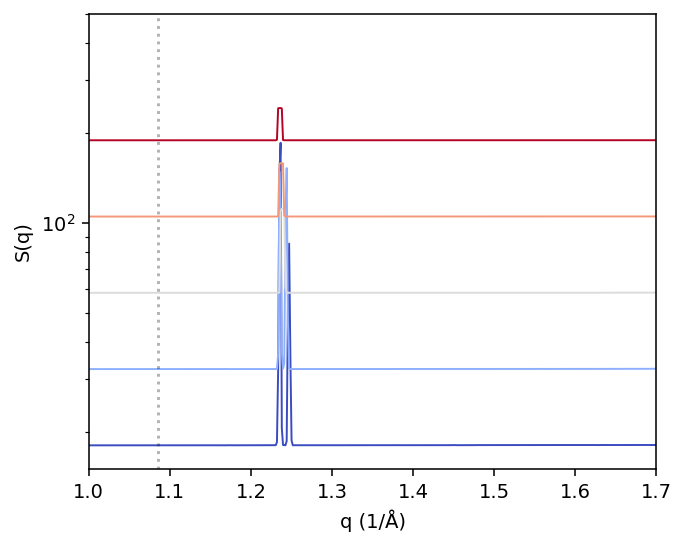

In [339]:
count = 10
fig = plt.figure(figsize=(5.0, 4), dpi=140)
ax = fig.add_subplot(111)
n = 5
ax.set_prop_cycle('color',[plt.cm.coolwarm(i) for i in np.linspace(0, 1, n)])
# plotting of gaussian spherical average S(q)
for temp, (q, Sq) in data_dict_qwidths.items():
    if temp%100 == 0:
        count = count*1.8
        print(temp)
        ax.plot(q, Sq+(count), '-', label=rf'{temp}', lw=1)

ax.set_xlabel('q (1/Å)')
ax.set_ylabel('S(q)')
ax.set_xlim([1, 1.7])
ax.legend(loc=2, fontsize=7)
#if log_yscale:
ax.set_yscale('log')
ax.set_ylim(15, 500)
#else:
#ax.set_ylim(0.0, 10)
ax.get_legend().remove()
fig.tight_layout()

/var/folders/z6/b_jzphk53190vbrxr2tb1l980000gn/T/ipykernel_62817/2105181945.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  orig_map=plt.cm.get_cmap('GnBu')


Text(0, 0.5, 'q (Ā)')

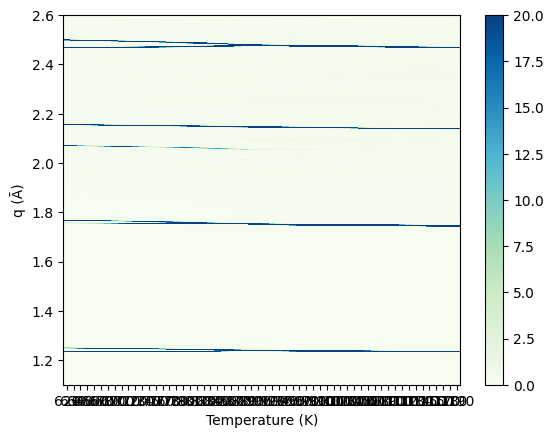

In [247]:
orig_map=plt.cm.get_cmap('GnBu') 
reversed_map = orig_map
plt.pcolormesh(T,q_array[0],df,cmap=reversed_map)
#plt.ylim([2.4,2.6])
plt.ylim([1.1,2.6])
#plt.xlim([880,940])
plt.colorbar()
plt.clim([0,20])
plt.xlabel("Temperature (K)")
plt.ylabel("q (Ā)")

In [197]:

for temp in np.arange(620,1200,10):
    text1 = f'/Users/prakriti/2024_BaZrS3_Phase_Transitions/XRD/XRD/'
    if temp < 890:
        dirname = f'BaZrS3_I4mcm_size4_T{temp}_seekpath/'
    else:
        dirname = f'BaZrS3_Pm-3m_size10_T{temp}_seekpath/'
    if not os.path.exists(f'{text1}{dirname}/dump.extxyz'):
        os.chdir(f'{text1}{dirname}')
        print("here")
        os.system('mv dump.xyz dump.extxyz')
        #os.chdir(f'../../../')

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


In [428]:
import os 
q_max = 3.0
q_linspace = np.linspace(0, q_max, 2000)
q_width = 0.001
data_dict_qwidths = dict()
# setup traj

for temp in np.arange(100,1200,50):
    if temp < 610:
        text1 = f'/Users/prakriti/2024_BaZrS3_Phase_Transitions/XRD_ortho/ortho/'
        dirname = f'equilibration-a+b-b--nat5040-T{temp}-P0-ns50000/'
    else:
        text1 = f'/Users/prakriti/2024_BaZrS3_Phase_Transitions/XRD/XRD/'
        if temp < 890:
            dirname = f'BaZrS3_I4mcm_size4_T{temp}_seekpath/'
        else:
            dirname = f'BaZrS3_Pm-3m_size10_T{temp}_seekpath/'
    print(text1+dirname)
    traj = Trajectory(text1 + dirname + 'dump.extxyz', trajectory_format='extxyz')


    # generate all q-points in supercell
    q_points = get_spherical_qpoints(traj.cell, q_max=q_max)

    # compute Sq
    sample = compute_static_structure_factors(traj, q_points)

    sample_averaged = get_spherically_averaged_sample_smearing(sample, q_norms=q_linspace, q_width=q_width)
    data_dict_qwidths[temp] = sample_averaged.q_norms, sample_averaged.Sq

/Users/prakriti/2024_BaZrS3_Phase_Transitions/XRD_ortho/ortho/equilibration-a+b-b--nat5040-T100-P0-ns50000/
INFO: Trajectory file: /Users/prakriti/2024_BaZrS3_Phase_Transitions/XRD_ortho/ortho/equilibration-a+b-b--nat5040-T100-P0-ns50000/dump.extxyz
INFO: Total number of particles: 5040
INFO: Number of atom types: 1
INFO: Number of atoms of type X: 5040
INFO: Simulation cell (in Angstrom):
[[42.05263143  0.          0.        ]
 [ 0.         42.83961451  0.        ]
 [ 0.          0.         70.23793906]]
INFO: Number of q-points: 7930
/Users/prakriti/2024_BaZrS3_Phase_Transitions/XRD_ortho/ortho/equilibration-a+b-b--nat5040-T150-P0-ns50000/
INFO: Trajectory file: /Users/prakriti/2024_BaZrS3_Phase_Transitions/XRD_ortho/ortho/equilibration-a+b-b--nat5040-T150-P0-ns50000/dump.extxyz
INFO: Total number of particles: 5040
INFO: Number of atom types: 1
INFO: Number of atoms of type X: 5040
INFO: Simulation cell (in Angstrom):
[[42.05263143  0.          0.        ]
 [ 0.         42.83961451 

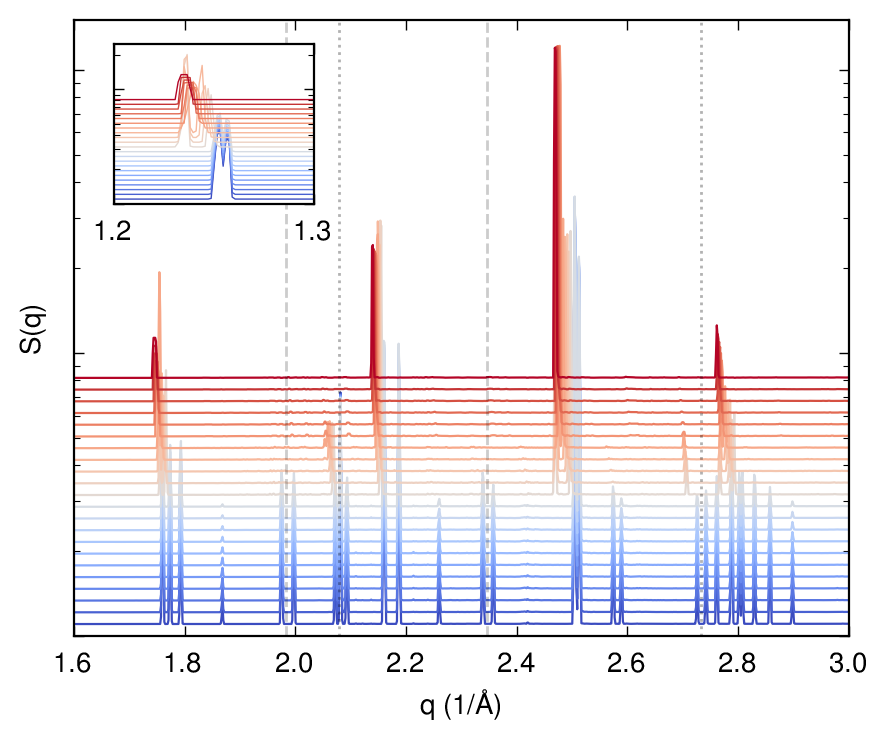

In [502]:
import mplpub
mplpub.setup(template='acs')

plt.rcParams['xtick.labelsize'] = 10  # Change font size

count = 10
fig = plt.figure(figsize=(5.0, 4), dpi=200)
ax = fig.add_subplot(111)
n = 22
ax.set_prop_cycle('color',[plt.cm.coolwarm(i) for i in np.linspace(0, 1, n)])
# plotting of gaussian spherical average S(q)
for temp, (q, Sq) in data_dict_qwidths.items():
    count = count*1.1
    if temp > 600:
    #    print(temp)
        ax.plot(q, Sq+(count), '-', label=rf'{temp}', lw=0.8)
    else:
        ax.plot(q, Sq+(count), '-', label=rf'{temp}', lw=0.8)

ax.set_xlabel('q (1/Å)', fontsize='10')
ax.set_ylabel('S(q)', fontsize='10')
ax.set_xlim([1.6, 3.0])
ax.legend(loc=2, fontsize=7)
#if log_yscale:
ax.set_yscale('log')
ax.set_ylim(10, 1500)
#else:
#ax.set_ylim(0.0, 10)

# Mark the cubic M-points
qvec_R1 = [1.5, 0.5, 0.5]
qvec_R2 = [1.5, 1.5, 0.5]
#qvec_R3 = [0.5, 0.5, 0.5]
qvec_M1 = [1.5, 0.5, 0]
qvec_M2 = [1.5, 0.5, 1.0]
q_R1 = 2 * np.pi / alat * np.linalg.norm(qvec_R1)
q_R2 = 2 * np.pi / alat * np.linalg.norm(qvec_R2)
q_R3 = 2 * np.pi / alat * np.linalg.norm(qvec_R3)
q_M1 = 2 * np.pi / alat * np.linalg.norm(qvec_M1)
q_M2 = 2 * np.pi / alat * np.linalg.norm(qvec_M2)
ax.axvline(x=q_R1, ls=':', color='k', alpha=alpha-0.2)
ax.axvline(x=q_R2, ls=':', color='k', alpha=alpha-0.2)
ax.axvline(x=q_M1, ls='--', color='k', alpha=alpha-0.3)
ax.axvline(x=q_M2, ls='--', color='k', alpha=alpha-0.3)
ax.set_yticklabels([])

left, bottom, width, height = [0.165, 0.65, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
n = 22
ax2.set_prop_cycle('color',[plt.cm.coolwarm(i) for i in np.linspace(0, 1, n)])
count = 10
for temp, (q, Sq) in data_dict_qwidths.items():
    count = count*1.1
    if temp > 600:
    #    print(temp)
        ax2.plot(q, Sq+(count), '-', label=rf'{temp}', lw=0.5)
    else:
        ax2.plot(q, Sq+(count), '-', label=rf'{temp}', lw=0.5)
ax2.set_yscale('log')
ax2.set_ylim(10, 250)
ax2.set_xlim([1.2, 1.3])
ax2.set_yticklabels([])
ax.get_legend().remove()
fig.savefig('XRD.png')
#fig.tight_layout()

In [360]:
for temp in np.arange(100,1200,100):
    if temp < 700:
        text1 = f'/Users/prakriti/2024_BaZrS3_Phase_Transitions/XRD_ortho/ortho/'
        dirname = f'equilibration-a+b-b--nat5040-T{temp}-P0-ns50000/'
    else:
        text1 = f'/Users/prakriti/2024_BaZrS3_Phase_Transitions/XRD/XRD/'
        if temp < 890:
            dirname = f'BaZrS3_I4mcm_size4_T{temp}_seekpath/'
        else:
            dirname = f'BaZrS3_Pm-3m_size10_T{temp}_seekpath/'
    print(text1+dirname)

/Users/prakriti/2024_BaZrS3_Phase_Transitions/XRD_ortho/ortho/equilibration-a+b-b--nat5040-T100-P0-ns50000/
/Users/prakriti/2024_BaZrS3_Phase_Transitions/XRD_ortho/ortho/equilibration-a+b-b--nat5040-T150-P0-ns50000/
/Users/prakriti/2024_BaZrS3_Phase_Transitions/XRD_ortho/ortho/equilibration-a+b-b--nat5040-T200-P0-ns50000/
/Users/prakriti/2024_BaZrS3_Phase_Transitions/XRD_ortho/ortho/equilibration-a+b-b--nat5040-T250-P0-ns50000/
/Users/prakriti/2024_BaZrS3_Phase_Transitions/XRD_ortho/ortho/equilibration-a+b-b--nat5040-T300-P0-ns50000/
/Users/prakriti/2024_BaZrS3_Phase_Transitions/XRD_ortho/ortho/equilibration-a+b-b--nat5040-T350-P0-ns50000/
/Users/prakriti/2024_BaZrS3_Phase_Transitions/XRD_ortho/ortho/equilibration-a+b-b--nat5040-T400-P0-ns50000/
/Users/prakriti/2024_BaZrS3_Phase_Transitions/XRD_ortho/ortho/equilibration-a+b-b--nat5040-T450-P0-ns50000/
/Users/prakriti/2024_BaZrS3_Phase_Transitions/XRD_ortho/ortho/equilibration-a+b-b--nat5040-T500-P0-ns50000/
/Users/prakriti/2024_BaZrS3_